In [61]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [62]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

In [63]:
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from src.utils import utils

PROJECT_DIR = os.getcwd()

## Preprocessing and Feature Extraction

In [64]:
config = {
    "dataset": {
        "input-type": "default",
        "args": {
            "dataset-dir": os.path.join(PROJECT_DIR, "dataset", "slam_stage3"),
            "steps": 5
        }
    },

    "camera": {
        "intrinsic": {
            "fx": 911.3753662109375,
            "fy": 911.1316528320312,
            "cx": 960.1340942382812,
            "cy": 544.84765625
        }
    },

    "feature": {
        "extractor": "sift",
        "matcher": "flann"
    }
}

In [65]:
class CVMP_Dataset:
    def __init__(self, config):
        self.config = config
        self._init_dataset()

    def __iter__(self):
        self.frame_idx = -1
        return self
    
    def __next__(self):
        self.frame_idx += 1
        if (self.frame_idx < len(self.image_list_rgb) - 1):
            try:
                return self.get_data()
            except:
                return None, None, None, None
        else:
            raise StopIteration

    def _init_dataset(self):
        def check_num_zeros(value):
            v_int = int(value)
            if v_int >= 0 and v_int < 10:
                return 8
            elif v_int >= 10 and v_int < 100:
                return 7
            else:
                return 6
        steps = self.config["dataset"]["args"]["steps"]
        # self.image_list_depth = sorted(glob.glob(os.path.join(self.config["dataset"]["args"]["dataset-dir"], "depth", "*.png")))[::steps]
        self.image_list_rgb   = sorted(glob.glob(os.path.join(self.config["dataset"]["args"]["dataset-dir"], "rgb", "*.png")))[::steps]

        img_names = sorted([float(os.path.basename(name)[:-4]) for name in self.image_list_rgb])

        self.image_list_rgb = [os.path.join(self.config["dataset"]["args"]["dataset-dir"], "rgb", format(i, f".{check_num_zeros(i)}f") + ".png") for i in img_names]
        self.image_list_depth = [os.path.join(self.config["dataset"]["args"]["dataset-dir"], "depth", format(i, f".{check_num_zeros(i)}f") + ".png") for i in img_names]

    def get_data(self):
        img0_gray   = cv2.imread(self.image_list_rgb[self.frame_idx],   cv2.IMREAD_GRAYSCALE)
        img0_depth  = cv2.imread(self.image_list_depth[self.frame_idx], cv2.IMREAD_GRAYSCALE)
        img1_gray   = cv2.imread(self.image_list_rgb[self.frame_idx+1],   cv2.IMREAD_GRAYSCALE)
        img1_depth  = cv2.imread(self.image_list_depth[self.frame_idx+1], cv2.IMREAD_GRAYSCALE)

        i0_name = os.path.basename(self.image_list_rgb[self.frame_idx])[:-4]
        return i0_name, img0_gray, img0_depth, img1_gray, img1_depth

In [66]:
class FeatureDetector:
    def __init__(self, config):
        self.config = config
        self.reset()

    def reset(self):
        # stores previous frame's keypoints and descriptors. so that it saves time to re-detect it again.
        self._is_initial = True
        self._kp_temp, self._des_temp = None, None
        self._init_feature_extractor()
        self._init_feature_matcher()

    def _init_feature_extractor(self):
        if self.config["feature"]["extractor"] == "orb":
            self.detector = cv2.ORB_create()
        elif self.config["feature"]["extractor"] == "sift":
            self.detector = cv2.SIFT_create()
        elif self.config["feature"]["extractor"] == "surf":
            self.detector = cv2.xfeatures2d.SURF_create()

    def _init_feature_matcher(self):
        if self.config["feature"]["matcher"] == "bf":
            if self.config["feature"]["extractor"] == "orb":
                self.matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
            elif self.config["feature"]["extractor"] == "sift":
                self.matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif self.config["feature"]["matcher"] == "flann":
            FLANN_INDEX_KDTREE = 1
            index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
    
    def _filter_matches(self, matches, dist_threshold=0.3):
        filtered_match = []
        for m, n in matches:
            if m.distance <= dist_threshold*n.distance:
                filtered_match.append(m)
        return filtered_match

    def detect(self, img0, img1, mask0=None, mask1=None, isSequence=True):
        if isSequence:
            if self._is_initial:
                kp0, des0 = self.detector.detectAndCompute(img0, mask0)
            else:
                kp0, des0 = self._kp_temp, self._des_temp
        else:
            kp0, des0 = self.detector.detectAndCompute(img0, mask0)
        kp1, des1 = self.detector.detectAndCompute(img1, mask1)

        matches = self.matcher.knnMatch(des0, des1, 2)
        matches = sorted(matches, key=lambda x:x[0].distance)
        filtered_matches = self._filter_matches(matches, 0.3)

        if isSequence and (len(filtered_matches) >= 6):
            self._kp_temp, self._des_temp = kp1, des1
            self._is_initial = False

        return kp0, kp1, matches, filtered_matches

In [114]:
class MotionEstimation(FeatureDetector):
    def __init__(self, config):
        super(MotionEstimation, self).__init__(config)
        self.pose_current = np.eye(4)
        self.pose_all = np.zeros((0, 4, 4))
        self.translation_scale_temp = 0.1

    def estimate(self, i0, i1, depth0=None, depth1=None, depth_max=1000):
        # detect features (from parent class)
        kp0, kp1, matches, filtered_matches = self.detect(i0, i1, isSequence=False)
        # if there are no match, simply return None. 
        # the temporary keypoints and descriptor are still well saved in the FeatureDetector class :)
        if len(filtered_matches) < 6:
            print("Warning: len filter less than 6")
            # return None, None, None

        # rotation and translation vector
        rmat, tvec = np.eye(3), np.zeros((3, 1))

        # extract matching points
        im0_points = np.float32([kp0[m.queryIdx].pt for m in filtered_matches])
        im1_points = np.float32([kp1[m.trainIdx].pt for m in filtered_matches])

        # get extrinsics from config
        fx, fy = self.config["camera"]["intrinsic"]["fx"], self.config["camera"]["intrinsic"]["fy"]
        cx, cy = self.config["camera"]["intrinsic"]["cx"], self.config["camera"]["intrinsic"]["cy"]
        k = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]).astype(np.float32)   

        # check depth
        if depth0 is not None:
            for r in sorted(0.1 * np.arange(1, 10)):
                new_filter_matches = self._filter_matches(matches, r)

                # extract matching points
                im0_points = np.float32([kp0[m.queryIdx].pt for m in new_filter_matches])
                im1_points = np.float32([kp1[m.trainIdx].pt for m in new_filter_matches])

                # use PnP method
                object_points_3d = np.zeros((0, 3))
                points_outliers = []

                # extract depth
                for i, (u, v) in enumerate(im0_points):
                    # find depth 
                    z = depth0[int(v), int(u)]
                    if z > depth_max or z == 0.0:
                        points_outliers.append(i)
                        continue

                    # if not outlier, extract x and y
                    x, y = z * (u - cx) / fx, z * (v - cy) / fy
                    object_points_3d = np.append(object_points_3d, np.array([[x, y, z]]), 0)

                # remove outlier
                im0_points = np.delete(im0_points, points_outliers, 0)
                im1_points = np.delete(im1_points, points_outliers, 0)

                # if not enough points for PnP, just cancel
                if len(im0_points) < 6 and len(object_points_3d) < 6:
                    print(f"len 3d less than 6")
                    continue

                # use PnP RANSAC
                _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points_3d.astype(np.float32), im1_points.astype(np.float32), k, None)

                # check if PnP not works well
                if np.linalg.norm(tvec) > 1:
                    print(f"pnp distance more than 1: r={r}, dist={np.linalg.norm(tvec)} start other iter")
                    continue

                self.translation_scale_temp = np.linalg.norm(tvec)

                # convert rvec to mat
                rmat = cv2.Rodrigues(rvec)[0]
                break
        else:
            # if depth not available, use essential matrix to find the movement
            E = cv2.findEssentialMat(im0_points, im1_points, k)[0]
            _, rmat, tvec, mask = cv2.recoverPose(E, im0_points, im1_points, k)

        # check if PnP not works well
        if np.linalg.norm(tvec) > 1:
            print(f"End - pnp distance more than 1: {np.linalg.norm(tvec)} start other iter")
            return None, None

        # conclude the results
        current_absolute_pose, current_relative_pose = self.track_trajectory(rmat, tvec)
        return current_absolute_pose, current_relative_pose

    def track_trajectory(self, rmat, tvec):
        T_mat = np.eye(4)
        T_mat[:3, :3] = rmat
        T_mat[:3, 3] = tvec.T

        self.pose_current = self.pose_current.dot(np.linalg.inv(T_mat))
        self.pose_all = np.append(self.pose_all, np.expand_dims(self.pose_current, 0), 0)

        return self.pose_current, T_mat

In [115]:
class Tools:
    def __init__(self):
        pass

    @staticmethod
    def blur_depth(i0_depth):
        depth_float = i0_depth.astype(float)
        kernel = np.ones((20, 20),np.float32)/400
        dst = cv2.filter2D(depth_float, -1, kernel)
        return dst

In [116]:
dataset = CVMP_Dataset(config)
feature_detect = FeatureDetector(config)
estimation = MotionEstimation(config)
poses = {}

mask = np.zeros(0)
for i, (i0_name, i0, i0_depth, i1, i1_depth) in enumerate(dataset):
    if not mask.size > 0:
        mask = (i0_depth > 0).astype(np.uint8)

    # extract trajectory
    current_pose_abs, current_pose_rel = estimation.estimate(i0=i0, i1=i1, depth0=i0_depth)
    if current_pose_rel is not None:
        poses[i0_name] = current_pose_rel.flatten().tolist()
    else:
        poses[i0_name] = None

    

len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
pnp distance more than 1: r=0.2, dist=10.695637022827494 start other iter
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
pnp distance more than 1: r=0.2, dist=14.90486658756767 start other iter
len 3d less than 6
pnp distance more than 1: r=0.2, dist=461.7088036722254 start other iter
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
len 3d less than 6
pnp distance more than 1: r=0.300000000

In [1]:
from scipy.spatial.transform import Rotation

def slerp(quat1, quat2, t):
    # Ensure quaternions are unit quaternions
    quat1 /= np.linalg.norm(quat1)
    quat2 /= np.linalg.norm(quat2)

    dot = np.dot(quat1, quat2)
    if dot < 0.0:
        quat1 = -quat1
        dot = -dot

    if dot > 0.9995:
        result = quat1 + t * (quat2 - quat1)
        return result / np.linalg.norm(result)

    th_0 = np.arccos(dot)
    th = th_0 * t
    sin_th = np.sin(th)
    sin_th_0 = np.sin(th_0)

    s0 = np.cos(th) - dot * sin_th / sin_th_0
    s1 = sin_th / sin_th_0

    return (s0 * quat1) + (s1 * quat2)

def interpolate_extrinsics(ext1, ext2, t):
    # Decompose the extrinsic matrices
    R1 = ext1[:3, :3]
    t1 = ext1[:3, 3]
    R2 = ext2[:3, :3]
    t2 = ext2[:3, 3]

    # Interpolate translation
    interpolated_t = (1 - t) * t1 + t * t2

    # Interpolate rotation
    r1, r2 = Rotation.from_matrix(R1), Rotation.from_matrix(R2)
    
    # Interpolate rotations using spherical linear interpolation (SLERP)
    quat_r = slerp(r1.as_quat(), r2.as_quat(), t)
    interpolated_r = Rotation.from_quat(quat_r).as_matrix()

    # Interpolate translation
    interpolated_t = (1 - t) * t1 + t * t2

    # Compose the interpolated extrinsic matrix
    interpolated_ext = np.eye(4)
    interpolated_ext[:3, :3] = interpolated_r
    interpolated_ext[:3, 3] = interpolated_t

    return interpolated_ext

In [118]:
def interpolate_empty_poses_in_dict(src_dict):
    poses_interpolate = src_dict.copy()

    # interpolate empty (None) relative poses
    poses_keys = list(poses_interpolate.keys()) 
    pose_0 = None
    pose_1 = None
    pose_skip_counter = 0
    pose_skipped_keys = []
    for k, v in poses_interpolate.items():
        # if there is None
        if v is None:
            print(f"None detected: {k}")
            print(f"inter start: {poses_keys[poses_keys.index(k) - 1]}")
            # store keys

            # look back to its previous available key
            pose_0 = np.array(poses_interpolate[poses_keys[poses_keys.index(k) - 1]]).reshape(4, 4).copy()
            # find the next poses
            for i in range(poses_keys.index(k), len(poses_keys)):
                if poses_interpolate[poses_keys[i]] is None:
                    # continue until found
                    pose_skip_counter += 1
                    pose_skipped_keys.append(poses_keys[i])
                    continue
                else:
                    print(f"inter end: {poses_keys[i]}")
                    pose_1 = np.array(poses_interpolate[poses_keys[i]]).reshape(4, 4).copy()
                    break

            # upon getting the 0th and 1st pose, interpolate the missing part
            ratios = np.linspace(0, 1, 2 + pose_skip_counter)
            for j, r in zip(pose_skipped_keys, ratios):
                print(f"   fixing for {j}")
                poses_interpolate[j] = interpolate_extrinsics(pose_0, pose_1, r).flatten().tolist()
            pose_skip_counter = 0
            pose_skipped_keys = []
            print()        
    return poses_interpolate

In [119]:
# interpolate RELATIVE empty poses in dict 
poses_interpolate = interpolate_empty_poses_in_dict(poses)

None detected: 98.4685110
inter start: 98.3018440
inter end: 98.6351660
   fixing for 98.4685110

None detected: 107.301844
inter start: 107.135188
inter end: 107.635177
   fixing for 107.301844
   fixing for 107.468500

None detected: 108.301844
inter start: 108.135166
inter end: 108.635177
   fixing for 108.301844
   fixing for 108.468511

None detected: 119.301844
inter start: 119.135177
inter end: 119.468500
   fixing for 119.301844

None detected: 119.801833
inter start: 119.635177
inter end: 121.635177
   fixing for 119.801833
   fixing for 119.968511
   fixing for 120.135177
   fixing for 120.301844
   fixing for 120.468500
   fixing for 120.635166
   fixing for 120.801833
   fixing for 120.968511
   fixing for 121.135166
   fixing for 121.301844
   fixing for 121.468500

None detected: 121.801833
inter start: 121.635177
inter end: 122.135177
   fixing for 121.801833
   fixing for 121.968511

None detected: 146.135177
inter start: 145.968511
inter end: 146.301833
   fixing for 1

In [120]:
# recalculate the absolute poses from the relative poses
image_list_full = np.array(glob.glob(os.path.join(config["dataset"]["args"]["dataset-dir"], "rgb", "*.png")))
img_name_float_sort = sorted([float(os.path.basename(name)[:-4]) for name in image_list_full])

all_poses_absolute = dict([(format(float(k), f".6f"), None) for k in img_name_float_sort])
cur_pose = np.eye(4)
for k, v in poses_interpolate.items():
    cur_pose = cur_pose.dot(np.linalg.inv(np.array(v).reshape(4, 4)))
    new_key = format(float(k), f".6f")
    if new_key in all_poses_absolute.keys():
        all_poses_absolute[new_key] = cur_pose.flatten().tolist()
        print(f"put {k} to {new_key}")
    else:
        print("None!")
        # print("its in all")

put 0.30186600 to 0.301866
put 0.46851100 to 0.468511
put 0.63517700 to 0.635177
put 0.80184400 to 0.801844
put 0.96850000 to 0.968500
put 1.13517700 to 1.135177
put 1.30185500 to 1.301855
put 1.46851100 to 1.468511
put 1.63517700 to 1.635177
put 1.80186600 to 1.801866
put 1.96852200 to 1.968522
put 2.13516600 to 2.135166
put 2.30185500 to 2.301855
put 2.46851100 to 2.468511
put 2.63517700 to 2.635177
put 2.80183300 to 2.801833
put 2.96851100 to 2.968511
put 3.13518800 to 3.135188
put 3.30184400 to 3.301844
put 3.46850000 to 3.468500
put 3.63517700 to 3.635177
put 3.80184400 to 3.801844
put 3.96850000 to 3.968500
put 4.13517700 to 4.135177
put 4.30184400 to 4.301844
put 4.46850000 to 4.468500
put 4.63517700 to 4.635177
put 4.80184400 to 4.801844
put 4.96850000 to 4.968500
put 5.13516600 to 5.135166
put 5.30184400 to 5.301844
put 5.46851100 to 5.468511
put 5.63517700 to 5.635177
put 5.80183300 to 5.801833
put 5.96850000 to 5.968500
put 6.13517700 to 6.135177
put 6.30183300 to 6.301833
p

In [121]:
# interpolate ABSOLUTE poses to get smooth path
all_poses_absolute_interpolate = interpolate_empty_poses_in_dict(all_poses_absolute)

None detected: 0.335200
inter start: 0.301866
inter end: 0.468511
   fixing for 0.335200
   fixing for 0.368500
   fixing for 0.401833
   fixing for 0.435166

None detected: 0.501844
inter start: 0.468511
inter end: 0.635177
   fixing for 0.501844
   fixing for 0.535177
   fixing for 0.568500
   fixing for 0.601844

None detected: 0.668522
inter start: 0.635177
inter end: 0.801844
   fixing for 0.668522
   fixing for 0.701833
   fixing for 0.735166
   fixing for 0.768511

None detected: 0.835166
inter start: 0.801844
inter end: 0.968500
   fixing for 0.835166
   fixing for 0.868500
   fixing for 0.901833
   fixing for 0.935177

None detected: 1.001844
inter start: 0.968500
inter end: 1.135177
   fixing for 1.001844
   fixing for 1.035177
   fixing for 1.068511
   fixing for 1.101833

None detected: 1.168511
inter start: 1.135177
inter end: 1.301855
   fixing for 1.168511
   fixing for 1.201844
   fixing for 1.235188
   fixing for 1.268522

None detected: 1.335200
inter start: 1.301855


In [122]:
# convert from homogenous matrix to quaternion and position, then save the poses into file
data = []
for k, v in all_poses_absolute_interpolate.items():
    # save key
    data_i = ""
    data_i += k + " "

    # save pos and rot
    mat = np.array(v).reshape(4, 4)
    pos = mat[:3, 3]
    rot = Rotation.from_matrix(mat[:3, :3])
    rot_quaternion = rot.as_quat()
    data_i += str(pos[0]) + " " + str(pos[1]) + " " + str(pos[2]) + " "
    data_i += str(rot_quaternion[0]) + " " + str(rot_quaternion[1]) + " " + str(rot_quaternion[2]) + " " + str(rot_quaternion[3])
    data.append(data_i)

# open file in write mode
filepath = os.path.join(config["dataset"]["args"]["dataset-dir"], "out_camera_trajectory.txt")
with open(filepath, 'w') as fp:
    for item in data:
        # write each item on a new line
        fp.write("%s\n" % item)
    print("Done saving file!")


Done saving file!


In [ ]:
# (optional for visualization below) save file as JSON
utils.export_json(os.path.join(config["dataset"]["args"]["dataset-dir"], "out_camera_trajectory.json"), all_poses_absolute_interpolate)

## Import trajectory from json file

In [127]:
import numpy as np
from src.utils import utils
import matplotlib.pyplot as plt

data_path = utils.import_json(os.path.join(config["dataset"]["args"]["dataset-dir"], "out_camera_trajectory.json"))
pose_all = np.array(list(data_path.values())).reshape(-1, 4, 4)

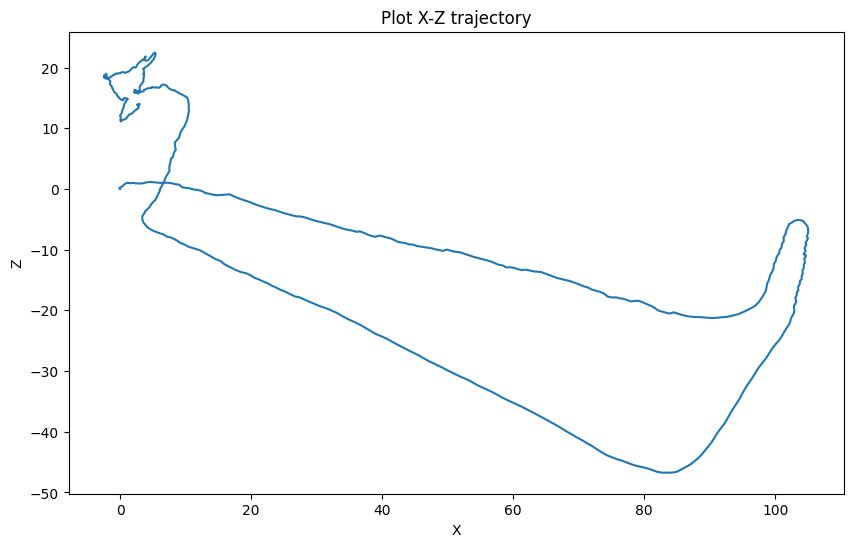

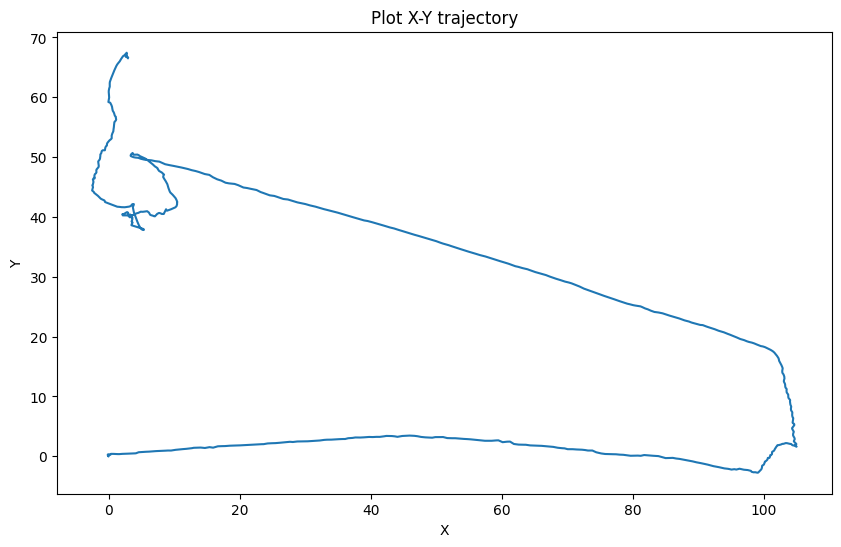

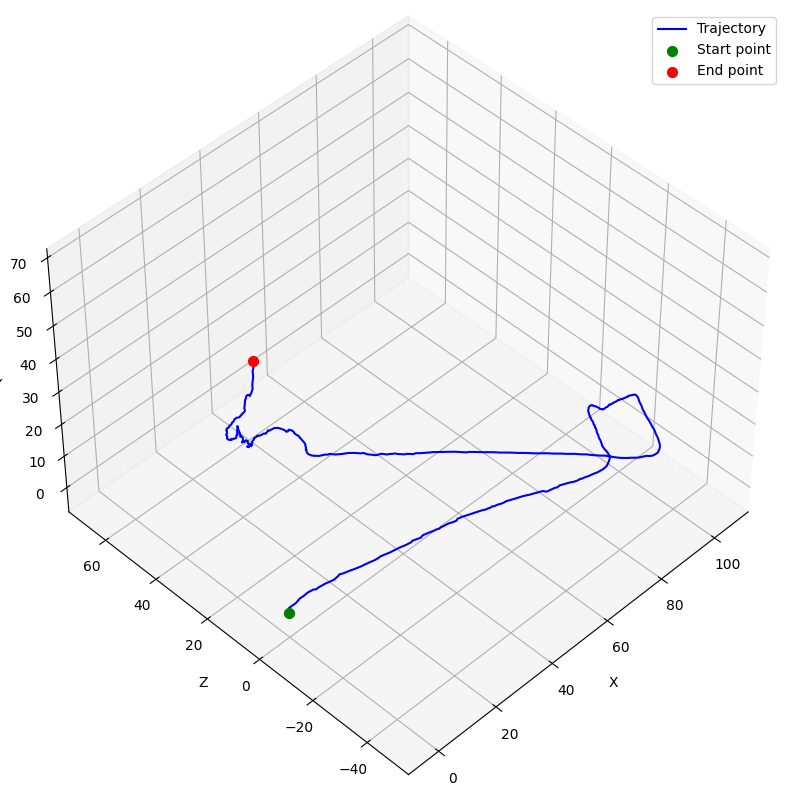

In [128]:
plt.figure(figsize=(10, 6))
plt.plot(pose_all[:, :3, 3][:, 0], pose_all[:, :3, 3][:, 2])
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Plot X-Z trajectory")

plt.figure(figsize=(10, 6))
plt.plot(pose_all[:, :3, 3][:, 0], pose_all[:, :3, 3][:, 1])
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Plot X-Y trajectory")

ax = plt.figure(figsize=(15, 10)).add_subplot(projection='3d')
ax.plot(xs=pose_all[:, :3, 3][:, 0], ys=pose_all[:, :3, 3][:, 1], zs=pose_all[:, :3, 3][:, 2], zdir='y', label='Trajectory', c='blue')
ax.scatter(xs=pose_all[:, :3, 3][:, 0][0], ys=pose_all[:, :3, 3][:, 1][0], zs=pose_all[:, :3, 3][:, 2][0], zdir='y', label='Start point', c='green', s=50)
ax.scatter(xs=pose_all[:, :3, 3][:, 0][-1], ys=pose_all[:, :3, 3][:, 1][-1], zs=pose_all[:, :3, 3][:, 2][-1], zdir='y', label='End point', c='red', s=50)


ax.view_init(elev=45., azim=-135, roll=0)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_zlabel("Y")
ax.legend()